In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
sys.path.append('./../../RoboPoint/')

from robopoint_utils import load_model, get_coordinates, generate_prompt, do_inference_with_logits, calculate_probs_per_coordinate
from utils import extract_all, plot_scatter, calculate_euclidian_distance, calculate_normalized_euclidian_distance, visualize_points_on_image, close_all_images, cluster_data, calculate_spread, show_cluster, calculate_roc_curve, plot_roc_curve, find_best_threshold
from PIL import Image

2025-03-16 12:07:07.223006: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 12:07:07.953355: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-16 12:07:07.953405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-16 12:07:07.953435: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 12:07:08.439588: I tensorflow/core/platform/cpu_feature_g

In [2]:
from matplotlib import pyplot as plt

def plot_scatter_report(labels, list_of_x, list_of_y, filename, title="Scatterplot", x_label="Distance to Groundtruth", y_label="Probabilities"):
    for label, x, y in zip(labels, list_of_x, list_of_y):
        plt.scatter(x, y, marker='o', label=label)
    
    # Adding labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc="lower right")
    
    # Show the plot
    plt.savefig(filename)
    plt.show()
    plt.close()

def apply_roc(scores, ground_truths, filename, title):
    fpr, tpr, roc_auc, thresholds = calculate_roc_curve(ground_truths, 0.1, scores)
    plot_roc_curve_report(fpr, tpr, roc_auc, filename, title)
    
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    return thresholds[best_idx], tpr[best_idx], fpr[best_idx]

def plot_roc_curve_report(fpr, tpr, roc_auc, filename, title = "Receiver Operating Characteristic (ROC) Curve for Distance-Based Classification"):
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Random classifier line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


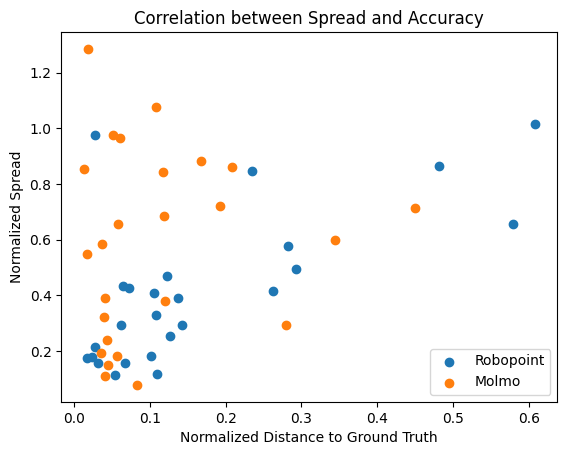

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


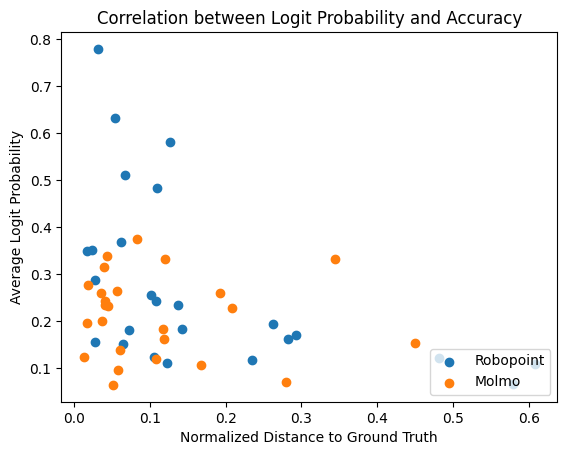

In [11]:
import itertools
import numpy as np

robopoint_data_file = 'results/Cluster_Scatter_ROC/robopoint-temp06-5prompts-6runs-certain-cluster.npz'
molmo_data_file = 'results/Cluster_Scatter_ROC/molmo-temp08-5prompts-6runs-certain-cluster.npz'

spreads_output_data_file = 'results/Cluster_Scatter_ROC/spreads-scatter.eps'
probs_output_data_file = 'results/Cluster_Scatter_ROC/probs-scatter.eps'

robopoint_loaded = np.load(robopoint_data_file)
distances_robopoint = robopoint_loaded['distances']
spreads_robopoint = robopoint_loaded['spreads']
probs_robopoint = robopoint_loaded['probs']

molmo_loaded = np.load(molmo_data_file)
distances_molmo = molmo_loaded['distances']
spreads_molmo = molmo_loaded['spreads']
probs_molmo = molmo_loaded['probs']

plot_scatter_report(["Robopoint","Molmo"], [distances_robopoint, distances_molmo], [spreads_robopoint, spreads_molmo], spreads_output_data_file, "Correlation between Spread and Accuracy", "Normalized Distance to Ground Truth", "Normalized Spread")

plot_scatter_report(["Robopoint","Molmo"], [distances_robopoint, distances_molmo], [probs_robopoint, probs_molmo], probs_output_data_file, "Correlation between Logit Probability and Accuracy", "Normalized Distance to Ground Truth", "Average Logit Probability")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


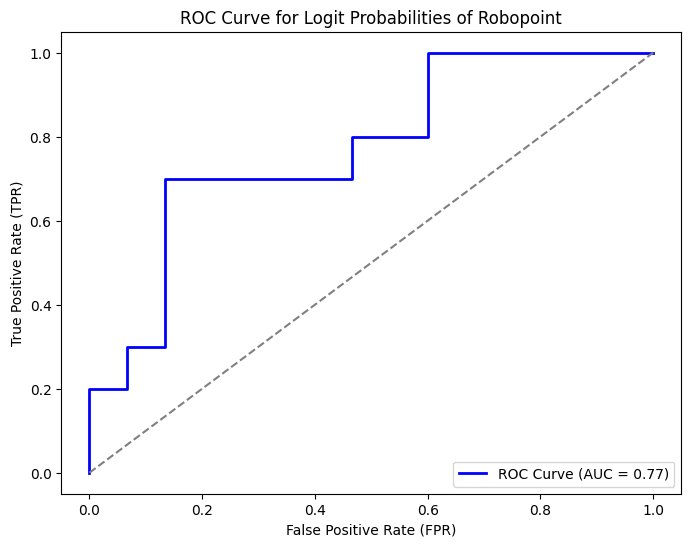

Best Threshold: 0.28799094359079996 with tpr = 0.7 and fpr = 0.13333333333333333


In [6]:
data_file = 'results/Cluster_Scatter_ROC/robopoint-temp06-5prompts-6runs-certain-cluster.npz'
output_data_file = 'results/Cluster_Scatter_ROC/probs-robopoint-roc.eps'

loaded = np.load(data_file)
distances = loaded['distances']
probs = loaded['probs']

threshold, tpr, fpr = apply_roc(probs, distances, output_data_file, "ROC Curve for Logit Probabilities of Robopoint")
print(f"Best Threshold: { threshold } with tpr = { tpr } and fpr = { fpr }")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


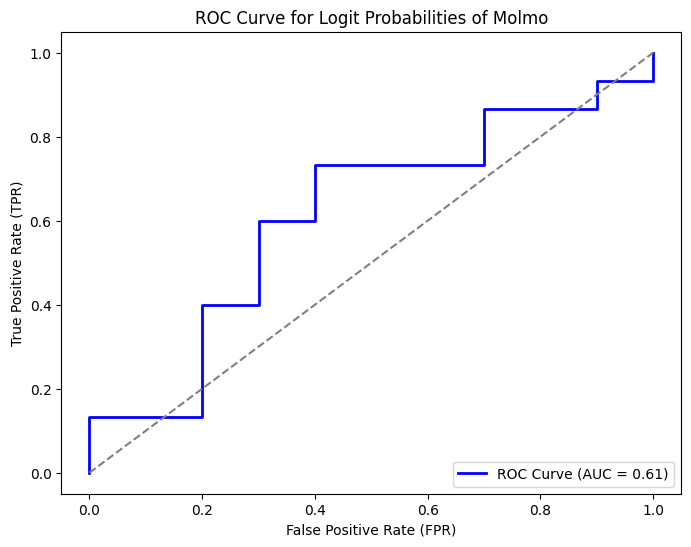

Best Threshold: 0.19569620539744695 with tpr = 0.7333333333333333 and fpr = 0.4


In [8]:
data_file = 'results/Cluster_Scatter_ROC/molmo-temp08-5prompts-6runs-certain-cluster.npz'
output_data_file = 'results/Cluster_Scatter_ROC/probs-molmo-roc.eps'

loaded = np.load(data_file)
distances = loaded['distances']
probs = loaded['probs']

threshold, tpr, fpr = apply_roc(probs, distances, output_data_file, "ROC Curve for Logit Probabilities of Molmo")
print(f"Best Threshold: { threshold } with tpr = { tpr } and fpr = { fpr }")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


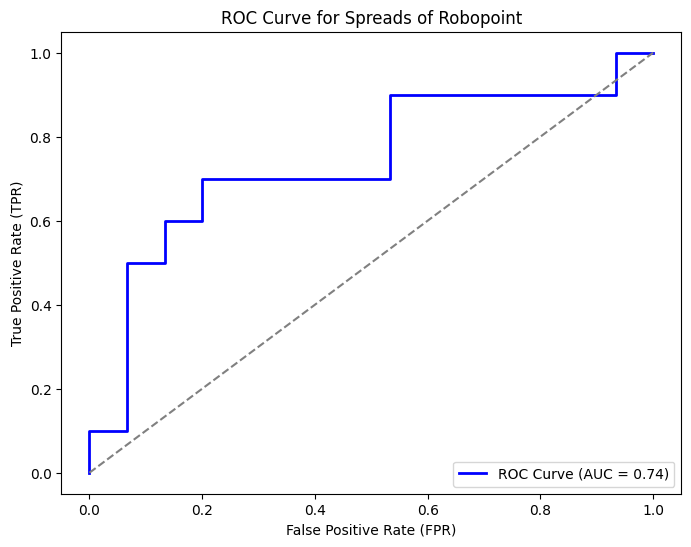

Best Threshold: 0.29202739597510363 with tpr = 0.7 and fpr = 0.2


In [9]:
data_file = 'results/Cluster_Scatter_ROC/robopoint-temp06-5prompts-6runs-certain-cluster.npz'
output_data_file = 'results/Cluster_Scatter_ROC/spreads-robopoint-roc.eps'

loaded = np.load(data_file)
distances = loaded['distances']
spreads = loaded['spreads']

threshold, tpr, fpr = apply_roc(1 - np.array(spreads), distances, output_data_file, "ROC Curve for Spreads of Robopoint")
print(f"Best Threshold: { 1 - threshold } with tpr = { tpr } and fpr = { fpr }")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


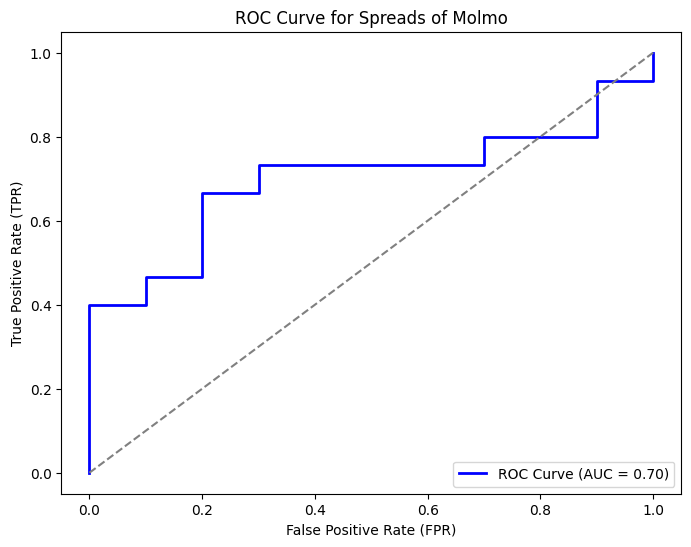

Best Threshold: 0.5841232746604094 with tpr = 0.6666666666666666 and fpr = 0.2


In [10]:
data_file = 'results/Cluster_Scatter_ROC/molmo-temp08-5prompts-6runs-certain-cluster.npz'
output_data_file = 'results/Cluster_Scatter_ROC/spreads-molmo-roc.eps'

loaded = np.load(data_file)
distances = loaded['distances']
spreads = loaded['spreads']

threshold, tpr, fpr = apply_roc(1 - np.array(spreads), distances, output_data_file, "ROC Curve for Spreads of Molmo")
print(f"Best Threshold: { 1 - threshold } with tpr = { tpr } and fpr = { fpr }")